# Import Libraries
     ~ Here I import all the libraries needed 

In [1]:
#import dependencies
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from keras import Model
from keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing import image
from matplotlib import style
from keras.models import *
import seaborn as sns
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
%matplotlib inline  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,TensorBoard,LearningRateScheduler
from keras.callbacks import EarlyStopping,CSVLogger
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
import tensorflow as tf
import random as rn
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import skimage.io
import skimage.transform
print("Libraries Loaded")

Using TensorFlow backend.


Libraries Loaded


# Hyperparameters
    ~ Here are my hyper parameters for my project. I will use thses later in my model

In [24]:
#hyperparameters for our model
batchsize=64
imgsize=150
height,width,channels=150,150,3
targetsize=(150,150)
classes = 7 
steps = 15
epochs = 30

armored_titan = '../input/titans/titans/armored'
attack_titan = '../input/titans/titans/attack'
beast_titan = '../input/titans/titans/beast'
cart_titan = '../input/titans/titans/cart'
colossal_titan = '../input/titans/titans/colossal'
female_titan = '../input/titans/titans/female'

print("Hyperparameters Ready")

Hyperparameters Ready


# Custom Functions For data loading
      ~ Here I create two empty lists to use for my functions
      ~ The first function is a helper function for labeling that I will use in by build function
      ~ My Build function that I created iterates through the data assigns the labels and reads the images into cv2, decodes the RGB, and resizes them.

In [10]:
X = []
Z = []
def label_assign(img,titan):
    return titan

def build(titan,dir):
    for img in tqdm(os.listdir(dir)):
        label = label_assign(img,titan)
        path = os.path.join(dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        X.append(np.array(img))
        Z.append(str(label))
print("Hyper Parameters Ready")

Hyper Parameters Ready


# Building My Data Using My Custom Function
    ~ Here I use my custom function to assign the labels to my data and build the dataset

In [4]:
build('Armored Titan',armored_titan)
build('Attack Titan',attack_titan)
build('Beast Titan',beast_titan)
build('Cart Titan',cart_titan)
build('Colossal Titan',colossal_titan)
build('Female Titan',female_titan)
print("Data Built And Labeled")

100%|██████████| 379/379 [00:05<00:00, 68.59it/s]

Data Built And Labeled


# After Building The Dataset Lets Look At Some Of The Images Of The DataSet
    ~ Here I use subplots from the matplotlib library to plot some examples.
    ~ I visualize these sample images along with their labels

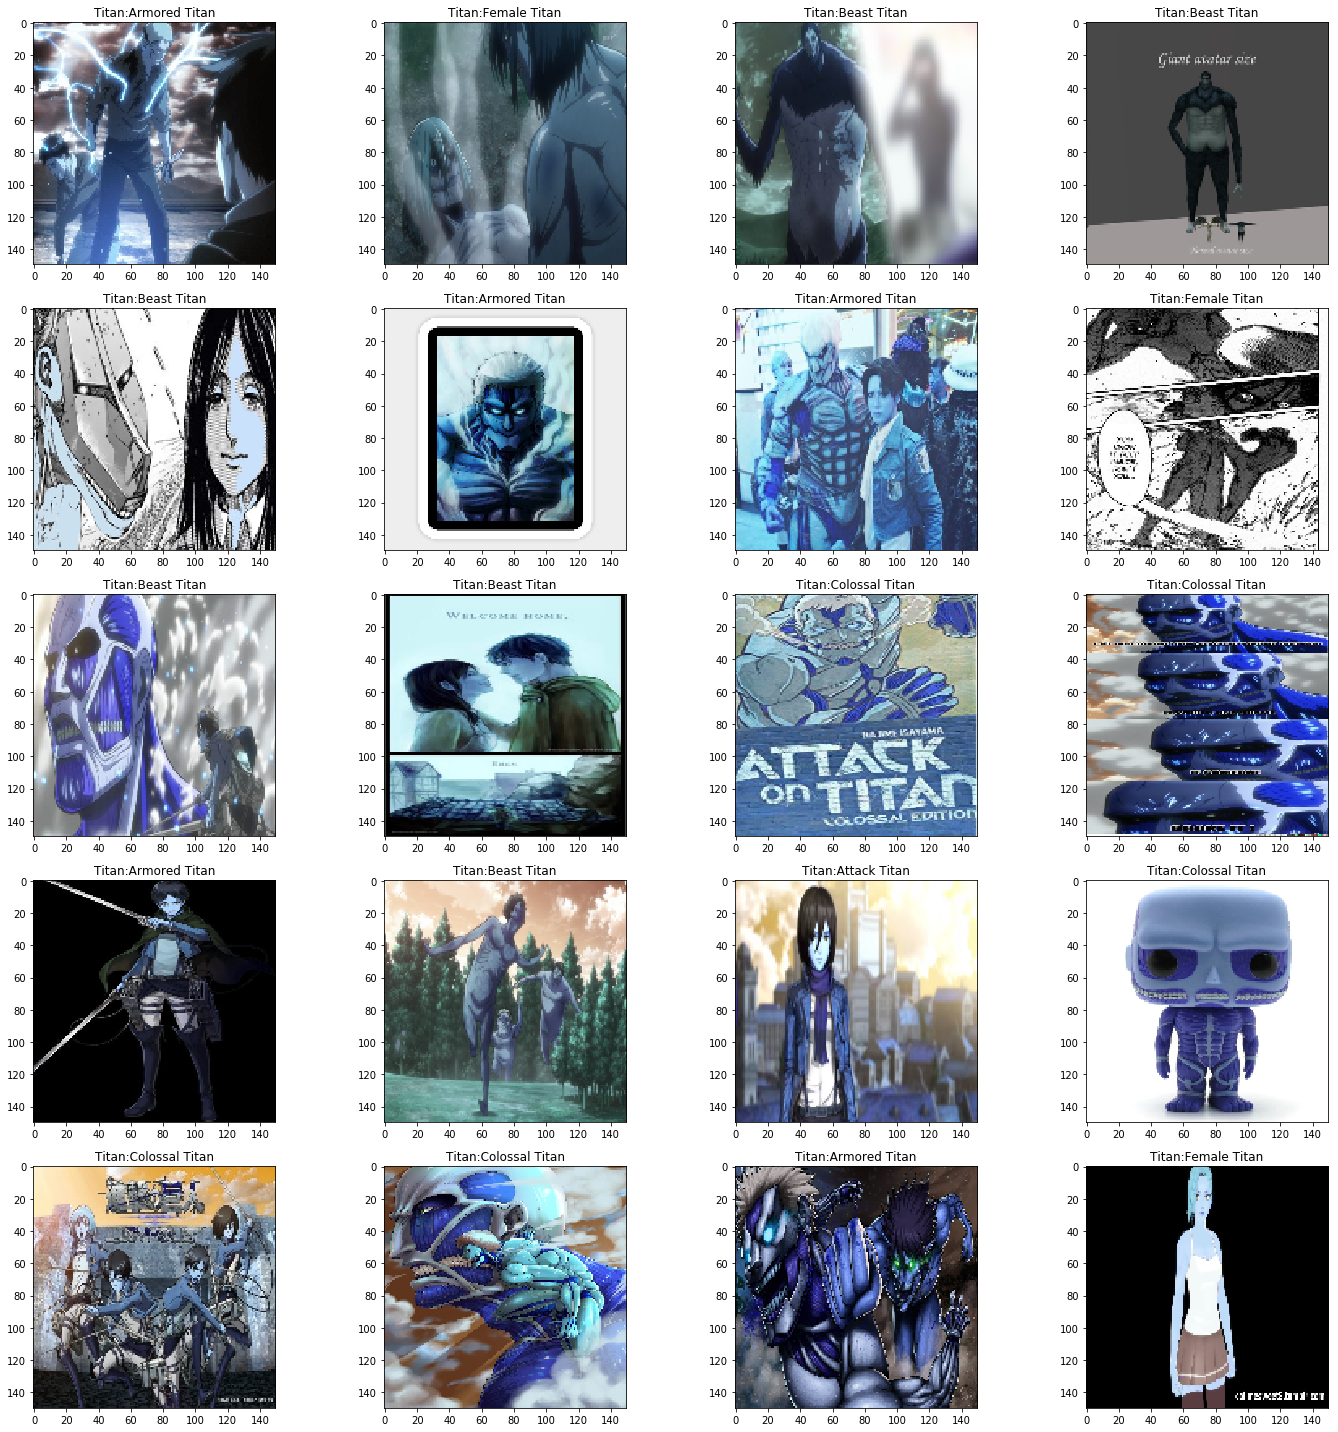

In [5]:
fig,ax = plt.subplots(5,4)
fig.set_size_inches(20,20)
for i in range(5):
    for j in range(4):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Titan:'+Z[l])
        
plt.tight_layout()

# Getting Data Ready For The Model 
    ~ First, I create my label encoder "lb"
    ~ I encode my labels by call "fit_transform"
    ~ I use to_categorical to encode my classes
    ~ I put "X" in a numpy array then normalized "X"
    ~ I use "train_test_split()" to create a validation set 

In [6]:
lb = LabelEncoder()
Y = lb.fit_transform(Z)
Y = to_categorical(Y,classes)
X = np.array(X)
X=X/255

x_trn,x_test,y_trn,y_test=train_test_split(X,Y,test_size=0.2,random_state=69)
print("Data Ready For The Model")

Data Ready For The Model


# The Model Architecture
    ~ I use a custom convolutional neural network
    ~ Picture Of My Model Architecture will be in the repository 

In [12]:
tmodel = Sequential()
tmodel.add(Conv2D(32,kernel_size= 7,activation='relu',input_shape=(width,height,channels)))
tmodel.add(BatchNormalization())
tmodel.add(MaxPool2D(pool_size=(2,2)))
tmodel.add(Conv2D(64,kernel_size = 6,activation='relu'))
tmodel.add(BatchNormalization())
tmodel.add(MaxPool2D(pool_size=(2,2)))
tmodel.add(Conv2D(96,kernel_size = 5,activation='relu'))
tmodel.add(BatchNormalization())
tmodel.add(MaxPool2D(pool_size=(2,2)))
tmodel.add(Conv2D(128,kernel_size = 4,activation='relu'))
tmodel.add(BatchNormalization())
tmodel.add(MaxPool2D(pool_size=(2,2)))
tmodel.add(Flatten())
tmodel.add(Dropout(0.25))
tmodel.add(Dense(256,activation='relu'))
tmodel.add(BatchNormalization())
tmodel.add(Dense(classes,activation='softmax',name='classifier'))
tmodel.add(BatchNormalization())
tmodel.summary()
print("Model Architecture Complete")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 144, 144, 32)      4736      
_________________________________________________________________
batch_normalization_6 (Batch (None, 144, 144, 32)      128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 67, 67, 64)        73792     
_________________________________________________________________
batch_normalization_7 (Batch (None, 67, 67, 64)        256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 96)        153696    
__________

# Data Augmentation/Data Generator
    ~ I create training and validation training generators to use data augmentation
    ~ Check the keras documentation to learning about what each transform does 

In [25]:
trn_augs = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)

val_augs = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False)

trn_gen = trn_augs.flow(np.array(x_trn),y_trn,batch_size=batchsize)

val_gen = val_augs.flow(np.array(x_test),y_test,batch_size=batchsize)

print("Data Augmentation Completed")

Data Augmentation Completed


# Compile The Model
    ~ I compile the model
    ~ You must always compile your model before you train it
    ~ The loss function: categorical_crossentropy
    ~ Optimizer: Adam
    ~ Metrics: categorical_accuracy

In [26]:
tmodel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
print("Tmodel: Compiled")

Tmodel: Compiled


# Callback
    ~ I use keras callbacks to monitor my training
    ~ Callback #1: ModelCheckpoint()
    ~ Callback #2: EarlyStopping()

In [27]:
weights="{}_weights.best.hdf5".format('player')


checkpoint = ModelCheckpoint(
weights,
monitor='val_loss',
verbose=1,
save_best_only=True,
mode='min',
save_weights_only=True)

reducelr = ReduceLROnPlateau(
monitor='val_loss',
verbose=1,
save_best_only=True,
mode='min',
save_weights_only=True)

earlystop = EarlyStopping(
monitor='val_loss',
min_delta=0.01,
patience=5,
verbose=1,
mode='min')

lrsched = LearningRateScheduler(lambda x: 0.4)

csvlogger = CSVLogger(
filename='../input/tmp/training.log',
separator=',',
append=False)

tensorboard = TensorBoard(
log_dir = './logs',
histogram_freq=0,
write_graph=True,
write_images=False,
embeddings_freq=100,
embeddings_layer_names=None,
embeddings_metadata=None)


callbacks = [checkpoint,earlystop]
print("CallBacks Ready!")

CallBacks Ready!


# Train The Model!
    ~ I use history to visualize the post training results
    ~ I call "fit_generator()" load my generators
    ~ I choose 30 steps per epoch with 20 epochs
    ~ Finally, I add my list of callbacks I defined earlier and train the model!

In [28]:
tmodel.fit_generator(
    trn_gen,
    steps_per_epoch=steps,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=steps,
    callbacks=callbacks
)

print("Tmodel: Training Complete")

Epoch 1/30
15/15 [==============================] - 13s 855ms/step - loss: 7.1571 - categorical_accuracy: 0.1482 - val_loss: 3.4865 - val_categorical_accuracy: 0.1387

Epoch 00001: val_loss improved from inf to 3.48645, saving model to player_weights.best.hdf5
Epoch 2/30
15/15 [==============================] - 9s 630ms/step - loss: 10.1726 - categorical_accuracy: 0.1490 - val_loss: 4.4615 - val_categorical_accuracy: 0.1377

Epoch 00002: val_loss did not improve from 3.48645
Epoch 3/30
15/15 [==============================] - 11s 708ms/step - loss: 11.8275 - categorical_accuracy: 0.1326 - val_loss: 4.6112 - val_categorical_accuracy: 0.1314

Epoch 00003: val_loss did not improve from 3.48645
Epoch 4/30
15/15 [==============================] - 9s 625ms/step - loss: 9.6840 - categorical_accuracy: 0.1573 - val_loss: 5.7651 - val_categorical_accuracy: 0.1303

Epoch 00004: val_loss did not improve from 3.48645
Epoch 5/30
15/15 [==============================] - 10s 658ms/step - loss: 9.2951 

# Freeze The Model(only if using transfer learning)
    ~ Here I freeze my model layers

In [29]:
tmodel_base.trainable = True
set_trainable = False

for layer in tmodel_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
print("Model Frozen")

NameError: name 'tmodel_base' is not defined

# Compile The Model
    ~ I compile the model
    ~ You must always compile your model before you train it
    ~ The loss function: categorical_crossentropy
    ~ Optimizer: Adam
    ~ Metrics: categorical_accuracy

In [30]:
tmodel.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['categorical_accuracy'])
print("Tmodel: Compiled")

Tmodel: Compiled


# Train The Model Again!(Only If using transfer learning)
    ~ I use history to visualize the post training results
    ~ I call "fit_generator()" load my generators
    ~ I choose 30 steps per epoch with 20 epochs
    ~ Finally, I add my list of callbacks I defined earlier and train the model!

In [31]:
history = tmodel.fit_generator(
    trn_gen,
    steps_per_epoch=steps,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=30,
    callbacks=callbacks
)

print("Tmodel: Training Complete")

Epoch 1/30
15/15 [==============================] - 18s 1s/step - loss: 8.1843 - categorical_accuracy: 0.1691 - val_loss: 8.7950 - val_categorical_accuracy: 0.1619

Epoch 00001: val_loss did not improve from 3.48645
Epoch 2/30
15/15 [==============================] - 13s 885ms/step - loss: 8.7211 - categorical_accuracy: 0.1740 - val_loss: 11.3438 - val_categorical_accuracy: 0.1566

Epoch 00002: val_loss did not improve from 3.48645
Epoch 3/30
15/15 [==============================] - 16s 1s/step - loss: 8.3873 - categorical_accuracy: 0.1615 - val_loss: 3.7659 - val_categorical_accuracy: 0.1531

Epoch 00003: val_loss did not improve from 3.48645
Epoch 4/30
15/15 [==============================] - 15s 971ms/step - loss: 8.6042 - categorical_accuracy: 0.1750 - val_loss: 5.2584 - val_categorical_accuracy: 0.1551

Epoch 00004: val_loss did not improve from 3.48645
Epoch 5/30
15/15 [==============================] - 15s 982ms/step - loss: 8.3218 - categorical_accuracy: 0.1764 - val_loss: 5.03

# Create Test Generator
    ~ Here I created a test generator


In [33]:
test_gen = trn_augs.flow(
    np.array(x_trn),
    y_trn,
    batch_size=batchsize)

test_loss, test_acc = tmodel.evaluate_generator(test_gen, steps=50)
print('test acc:', test_acc)

test acc: 0.17145563622999538


# Visualize the training
    ~ I Visualize the training the training using the history object I defined earlier before fitting

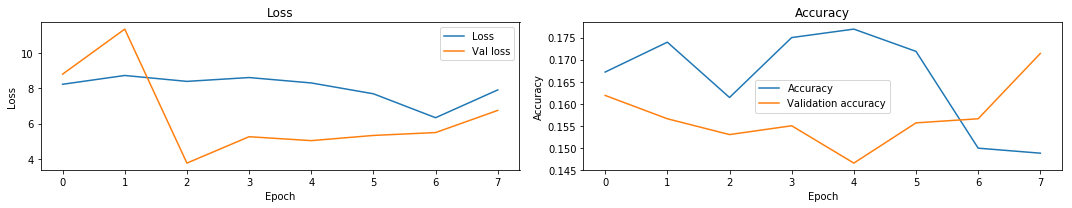

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].plot(history.history['loss'], label="Loss")
axes[0].plot(history.history['val_loss'], label="Val loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()


axes[1].plot(history.history['categorical_accuracy'], label="Accuracy")
axes[1].plot(history.history['val_categorical_accuracy'], label="Validation accuracy")
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.show()

# Model Evaluation
    ~ I call "tmodel.evaluate()" to anaylze the training and evaluate the models performance

In [35]:
tmodel_eval = tmodel.evaluate(x_test,y_test,verbose=1)
print("Tmodel: Evaluation: Test Loss", tmodel_eval[0])
print("Tmodel: Test Accuracy",tmodel_eval[1])

568/568 [==============================] - 1s 1ms/step
Tmodel: Evaluation: Test Loss 6.994292010723705
Tmodel: Test Accuracy 0.16901408461198


# Collecting The Model Predictions
    ~ Here I collect the models predictions by call "tmodel.predict()"

In [36]:
tmodel_predictions = tmodel.predict(x_test,verbose=1)
y_tmodel_predictions = np.argmax(tmodel_predictions,axis=1)
print("Tmodel: Predictions Collected")

568/568 [==============================] - 1s 2ms/step
Tmodel: Predictions Collected


# Save The Model
    ~ Here I save the model to a json and h5 file
    ~ json: I save this model to a json file to save a copy of the models structure
    ~ h5: I save this model in an h5 format to save a copy of the models weights
    ~ You should do this if you plan on later developing an application for your model

In [37]:
tmodel_json = tmodel.to_json()
with open("tmodel_titan.json","w") as json_file:
    json_file.write(tmodel_json)
    
tmodel.save_weights("tmodel_titan.h5")

print("Tmodel: Structure And Weights Saved")

Tmodel: Structure And Weights Saved


# Process A Single Image For Visualization
    ~ Here I process a single image to later visualize it
    ~ After processing I print the image shape

In [38]:
img_path = '../input/titans/titans/attack/00000005.jpg'
img = image.load_img(img_path, target_size=targetsize)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


# Visualize Test image
    ~ Here I visualize a test image

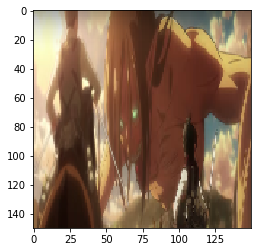

In [39]:
plt.imshow(img_tensor[0])
plt.show()

# The End!
    ~ Thank You For Viewing My Project!
    ~ Created By: Terrance Whitehurst

# My Deep learning Blog
 ~ https://medium.com/@TerranceWhitehurst
 
 ~ Happy Learning!